# Tutorial 02: Domain Specific Language, Attribute, and Group

At the core of Errudite is an expressive domain-specific language (DSL) for precisely querying instances based on linguistic features. Using composable building blocks in DSL, Errudite supports forming semantically meaningful groups and rewriting instances to test counterfactuals across all available validation data.

This section discusses the DSL, and the grouping. We leave rewriting to tutorial 03.

### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

def import_sys():
    import sys
    sys.path.append('..')
import_sys()

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)  # pylint: disable=invalid-name

import errudite
print(errudite)

<module 'errudite' from '../errudite/__init__.py'>


In [2]:
# set the dataset reader
from errudite.io import DatasetReader

cache_folder_path = "./data/snli_tutorial_caches/"
reader = DatasetReader.by_name("snli")(
    cache_folder_path=cache_folder_path)

# load the data saved 
"""
Re-store all the preprocessed information in 01-preprocess.ipynb. 
In specific, it reloads:

1. Instances
2. Set the predictions from models as entries of the instances, 
   and set Instance.instance_hash, Instance.instance_hash_rewritten, and Instance.qid_hash.
3. Get the Instance.ling_perform_dict, which saves the relationship
   between linguistic features and model performances, and 
   Instance.train_freq, which saves the training vocabulary 
   frequency.
"""
instances = reader.load_preprocessed()

INFO:errudite.utils.file_utils:Errudite cache folder selected: ./data/caches/snli_tutorial/
INFO:errudite.io.dataset_reader:Loaded 100 objects to ./data/caches/snli_tutorial/instances.pkl.
INFO:errudite.io.dataset_reader:Loaded 100 objects to ./data/caches/snli_tutorial/evaluations/decompose_att.pkl.


In [3]:
from errudite.targets.instance import Instance
# take a look at the recovered instance
instance = list(Instance.instance_hash.values())[0]
instance.show_instance()

[Instance] [InstanceKey(qid='4705552913.jpg#2r1n', vid=0)]
[hypothesis]	The sisters are hugging goodbye while holding to go packages after just eating lunch.
[premise]	Two women are embracing while holding to go packages.
[groundtruth]	neutral	groundtruth	{}
[predictions]	neutral	decompose_att	{'accuracy': 1.0, 'confidence': 0.9986408352851868}



## Domain Specific Language
---

### General information & base class
Errudite has a DSL language that: 

1. Use primitive functions that run on targets to extract fundamental instance metadata (e.g., `length(premise)` returns the length of a question). 
2. Allows string command inputs, which can be automatically parsed into actual primitive functions. The objective here is, we try to query the frequently used targets more easily for you. On a high level, parser works as the following:
    - If it recognizes a target name that occurrs in `instance.entries`, it automatically retrive the target.
    - If it recognizes a registered primitive function, it runs the function.
    - It also supports more general operators like `>`, `<=`, `and`, `or`, etc.
    - It resolves previously created attributes ("attr:attr_name") and groups (("group:group_name")).

There is a basic wrapper class, `errudite.build_blocks.PrimFunc` ([documentation](https://errudite.readthedocs.io/en/latest/api/errudite.build_blocks.prim_funcs.html)), to wrap all the functions up.

### Predefined primitive functions
Errudite also has a list of predefined functions to support computing instance attributes and/or build instance groups. The functions can be divided into several types:

1. basic extractors like `length`,
2. general purpose linguistic features like token `LEMMA`, `POS` tags, and entity (`ENT`) annotations,
3. standard prediction performance metrics such as `f1` or `accuracy`, 
4. between-target relations such as `overlap(t1, t2)`, and 
5. domain-specific attributes (e.g., for Machine Comprehension or Visual Question Answering) such as `question_type` and `answer_type`/

Checkout the [documention](https://errudite.readthedocs.io/en/latest/api/errudite.build_blocks.prim_funcs.html) of the pre-defined functions here!

### Function extension

Just like `DatasetReader` and `Predictor`, `PrimFunc` allows extension through `register`. For example, if you are interested in learning the length difference between two targets, you could register a function as below:

In [4]:
from errudite.build_blocks import PrimFunc

@PrimFunc.register()
def delta_length(t1: 'Target', t2: 'Target') -> int:
    """
    The length diff of two given targets.
    """
    output = None
    try:
        output = len(t1.doc) - len(t2.doc)
    except Exception as e:
        ex = Exception(f"Unknown exception from [ delta_length ]: {e}")
        raise(ex)
    else:
        return output

## DSL built into Attributes & Groups
---

Errudite’s DSL and operators can be used to:

1. Extract complex attributes from instances, and
2. Create semantically meaningful groups.

### Base classes

Both `Attribute` and `Group` are implemented under a base class called `Store` ([documentation](https://errudite.readthedocs.io/en/latest/api/errudite.utils.store.html)). It stores the objects in a hash variable, so all the created objects and analyses can be easily queried and used in various functions. `[Attribute|Group].store_hash()` gets the dicts saving the created attributes and groups. `Store` also has `keys()`, `values()`, and `items()`, which makes `Store` usable just as a dict.

### Attributes

Attributes are quantitave information from instances. Extracting them helps you check certain interesting distributions. Creating an attribute and running it on instances is easy. Let's create an attribute that extracts the distribution of `len(premise) - len(hypothesis)`, with the function we've just created (Note that this function can take more optional arguments -- Checkout the[ documentation](https://errudite.readthedocs.io/en/latest/api/errudite.builts.attribute.html) for more details): 

In [5]:
from errudite.builts import Attribute
attr = Attribute.create(
    # The name of the attribute
    name="delta_len_premise_hypo",
    # the description of the attribute
    description="The length delta between the premise and the hypothesis",
    # The command that extracts attributes from instances
    # Input in string, it will be parsed by the DSL to 
    # actual functions.
    cmd="delta_length(premise, hypothesis)")

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(delta_length):[ArgOp:premise, ArgOp:hypothesis]+[]
INFO:errudite.builts.attribute:Created attr: delta_len_premise_hypo


Once created, you could see what instances are available, and what are their attributes:

In [6]:
attr.get_instances()

defaultdict(None,
            {InstanceKey(qid='4705552913.jpg#2r1n', vid=0): -5,
             InstanceKey(qid='4705552913.jpg#2r1e', vid=0): 4,
             InstanceKey(qid='4705552913.jpg#2r1c', vid=0): 2,
             InstanceKey(qid='2407214681.jpg#0r1e', vid=0): 25,
             InstanceKey(qid='2407214681.jpg#0r1n', vid=0): 25,
             InstanceKey(qid='2407214681.jpg#0r1c', vid=0): 26,
             InstanceKey(qid='4718146904.jpg#2r1c', vid=0): 8,
             InstanceKey(qid='4718146904.jpg#2r1n', vid=0): -2,
             InstanceKey(qid='4718146904.jpg#2r1e', vid=0): 10,
             InstanceKey(qid='3980085662.jpg#0r1e', vid=0): 14,
             InstanceKey(qid='3980085662.jpg#0r1c', vid=0): 12,
             InstanceKey(qid='3980085662.jpg#0r1n', vid=0): 13,
             InstanceKey(qid='24467676.jpg#1r1n', vid=0): 14,
             InstanceKey(qid='24467676.jpg#1r1e', vid=0): 13,
             InstanceKey(qid='24467676.jpg#1r1c', vid=0): 13,
             InstanceKey(qid='3

You can also extract one attribute from one instance:

In [7]:
# then the group is ready for testing
attr.test_one_instance(instance)

-5

#### Check attribute distribution

We provide visualization from [Altair](http://altair-viz.github.io) to display the attribute distribution. The visualization is a histogram that displays the relative frequency of different attribute values, as well as the proportion of incorrect predictions. Because of the incorrect prediction proportion, this historgram is different for each different model.

If categorical, each value is a bar. Otherwise, the domain is automatically binned, and each bin is a bar.

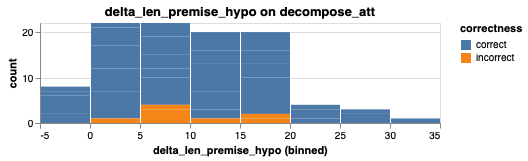

In [8]:
attr.visualize_models(models=["decompose_att"])

### Group

`Group`s ([documentation](https://errudite.readthedocs.io/en/latest/api/errudite.builts.group.html)) helps filter and put together instances that share similar attributes together, through filters created through the DSL.

`Group`s are extremely similar to attributes, only that instead of saving a value per instance, it saves a list of instance keys that satisfies certain filter.

Here, we build a group where the absolute length diferences between the premises and the hypothses are larget than 5.

Note that all the previously created attributes and groups can be used and queried, as long as we serve the stored attributes and groups as part of the inputs.

In [9]:
from errudite.builts import Group
group = Group.create(
    # The name of the attribute
    name="large_diff_length",
    # the description of the attribute
    description="The input length is very different.",
    # All the previously created attributes and groups 
    # can be used and queried, as long as we serve the 
    # stored attributes and groups as part of the inputs.
    cmd="abs_num(attr:delta_len_premise_hypo) > 5",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)
group.get_instances()

INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](>):[FuncOp(abs_num):[ArgOp:[BuildBlockOp](attr):delta_len_premise_hypo]+[], 5.0]
INFO:errudite.builts.group:Created group: large_diff_length


defaultdict(None,
            {InstanceKey(qid='2407214681.jpg#0r1e', vid=0): True,
             InstanceKey(qid='2407214681.jpg#0r1n', vid=0): True,
             InstanceKey(qid='2407214681.jpg#0r1c', vid=0): True,
             InstanceKey(qid='4718146904.jpg#2r1c', vid=0): True,
             InstanceKey(qid='4718146904.jpg#2r1e', vid=0): True,
             InstanceKey(qid='3980085662.jpg#0r1e', vid=0): True,
             InstanceKey(qid='3980085662.jpg#0r1c', vid=0): True,
             InstanceKey(qid='3980085662.jpg#0r1n', vid=0): True,
             InstanceKey(qid='24467676.jpg#1r1n', vid=0): True,
             InstanceKey(qid='24467676.jpg#1r1e', vid=0): True,
             InstanceKey(qid='24467676.jpg#1r1c', vid=0): True,
             InstanceKey(qid='3667788497.jpg#0r1e', vid=0): True,
             InstanceKey(qid='3667788497.jpg#0r1n', vid=0): True,
             InstanceKey(qid='3667788497.jpg#0r1c', vid=0): True,
             InstanceKey(qid='3948003394.jpg#1r1e', vid=0): True

`test_instance()` in `group` objects test whether or not one instance belongs to the group:

#### Visualize grouped instance performance

The visualization for a group is a one-bar histogram that displays the count of instances in the group, and the proportion of incorrect predictions. Similar to attributes, because of the incorrect prediction proportion, this historgram is different for each different model.

If categorical, each value is a bar. Otherwise, the domain is automatically binned, and each bin is a bar.

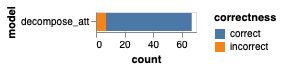

In [10]:
group.visualize_models(models=["decompose_att"])

We could also print the instance correctness for the given filtering instance in numbers:

```python
{
    'counts': {
        'correct': # The number of correct predictions in
                   # filtered_instances,
        'incorrect': # The number of incorrect predictions in 
                     # filtered_instances,
    },
    'stats': {
        'coverage': # (count_correct + count_incorrect) / TOTAL_SIZE,
        'error_coverage': # The ratio of how many incorrect 
                          # instances are covered.
        'local_error_rate': # The ratio of incorrect instances 
                            # within filtered_instances.
        'global_error_rate': # count_incorrect / TOTAL_SIZE
    }
}
```

In [11]:
# some general stats on groups
Group.eval_stats(
    filtered_instances=group.get_instances(),
    # this will automatically call the default model we got
    model=None
)

{'counts': {'correct': 60, 'incorrect': 7},
 'stats': {'coverage': 0.67,
  'error_coverage': 0.875,
  'local_error_rate': 0.1044776119402985,
  'global_error_rate': 0.07}}

## Attributes and Groups defined with customized functions

As we've seen, pne way to extend the DSL/attribute/group is to register new primitive functions and allow them to be recognized when we parse string `cmd`s. 

However, when the extractor/filtering function is unique enought that you would prefer not to reuse it, it's also possible to override `cmd` with a function that directly takes an `instance` as an input. Here, we create exactly the same group as before, with a raw function:

INFO:errudite.build_blocks.wrapper:Parsed: <function BuildBlockWrapper._parse_cmd_func.<locals>.test_func at 0x10cad5268>
INFO:errudite.builts.group:Created group: large_diff_length_from_func


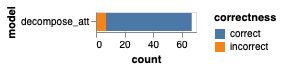

In [12]:
def large_diff_length_func(instance, **kwargs):
    premise = instance.get_entry('premise')
    hypothesis = instance.get_entry('hypothesis')
    if premise and hypothesis:
        delta_length = len(premise.doc) - len(hypothesis.doc)
        return abs(delta_length) > 5 
    return False

group = Group.create(
    name="large_diff_length_from_func",
    description="The input length is very different.",
    cmd=large_diff_length_func,
)
group.visualize_models(models=["decompose_att"])

## Functions supporting qureries

As mentioned before, `Group` and `Attribute` can be used as `store dict`. You can get all the saved attributes by calling:
```python
Attribute.store_hash()
```

Get the names of attributes by calling: 
```python
list(Attribute.keys())
```

Get the actual attribute list by calling: 
```python
list(Attribute.values())
```

Query one attribute by calling: 
```python
list(Attribute.get("attr_name"))
```

# Save & reload

All attributes and groups (and in fact, rewrite rules as we will see)  are expressed and saved as precise queries, enabling reproducible analyses -- We can just share the definitions in json formats. With the `export_to_file` function, the json definitions are exported to `{cache_folder}/analysis/`:

```sh
[cache folder]
└── analysis 
    ├── save_attr.json
    ├── save_group.json
    └── save_rewrite.json
```

In [21]:
Attribute.export_to_file(file_name="save_attr.json")
Group.export_to_file(file_name="save_group.json")

INFO:errudite.utils.store:Done saving to ./data/caches/snli_tutorial/analysis/save_attr.json
INFO:errudite.utils.store:Done saving to ./data/caches/snli_tutorial/analysis/save_group.json


True

Reloading is also easy:

In [22]:
# reload 
Attribute.import_from_file('save_attr.json')
Group.import_from_file('save_group.json')

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(delta_length):[ArgOp:premise, ArgOp:hypothesis]+[]
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](>):[FuncOp(abs_num):[ArgOp:[BuildBlockOp](attr):delta_len_premise_hypo]+[], 5.0]
INFO:errudite.build_blocks.wrapper:Parsed: <function BuildBlockWrapper._parse_cmd_func.<locals>.test_func at 0x13b3a9950>


{'large_diff_length': [Group](large_diff_length): 
 	CMD	: abs_num(attr:delta_len_premise_hypo) > 5
 	COUNT	: 0,
 'large_diff_length_from_func': [Group](large_diff_length_from_func): 
 	CMD	: <function large_diff_length_func at 0x13a8c47b8>
 	COUNT	: 0}

In [25]:
Group.get("large_diff_length_from_func").test_one_instance(instance)

False